# Final Year Project General Notebook

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.sparse.linalg import eigs

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from rc_datasets import rc_datasets

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def nmse(y_pred,y_true):
    return mean_squared_error(y_pred,y_true)/np.var(y_true)

In [17]:
class Esn:
    
    # Initialise global variables at object creation
    def __init__(self,data,alpha=0.5,beta=10**-4,in_nodes=1,out_nodes=1,N=1000,rhoscale=1.25,Ttrain=2000,Twashout=100, seed_init=0):
        # read parameters
        np.random.seed(seed_init) # add seed as parameter
        self.alpha = alpha
        self.beta = beta
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.N = N
        self.Ttrain = Ttrain
        self.Twashout = Twashout

        # let's save the relevant time-steps for convenience
        self.T1=Twashout
        self.T2=Ttrain+Twashout
        
        # load and store the dataset
        self.data=data
        # include row of ones as an input to the network
        self.data_input=np.concatenate((np.ones((1,data.shape[1])),data))
        
        # init matrices and vectors
        self.x = np.zeros(N) # column vector
        self.Win = np.random.uniform(low=-.5, high=.5, size=(N,in_nodes+1))
        self.W = np.random.uniform(low=-1.5, high=1.5, size=(N,N))
        self.Wout = np.zeros((out_nodes, 1+in_nodes+N))
        
        # init measurement matrix
        self.M_train = np.zeros((in_nodes+N+1,Ttrain))
        
        # Complete scale factor for W
        #eigs, _ = eig(self.W)                        # tuple containing eigen values + eigen vectors
        #eigs_abs = [abs(k) for k in eigs]            # compute absolute eigen values
        #eigs_abs.sort(reverse=True)                  # sort by largest
        #self.rhoscale = rhoscale/eigs_abs[0]         # adjust rhoscale using largest eigen value
        #self.W = self.W*rhoscale                     # scale spectral radius of W             
        eig,_=eigs(self.W,k=1,which='LM',tol=1e-3)
        rhoscale=rhoscale/abs(eig);                  # scaling factor 
        self.W=self.W*rhoscale;                                 # scale spectral radius of W 
        
    # ===============================================================
    # Training stage: extract M matrix
    def train_M(self):
        # store input and expected output in vectors
        self.X_train=self.data[:,self.T1:self.T2]
        self.Y_train=self.data[:,self.T1+1:self.T2+1]
        
        for i in range(self.Twashout):
            self.x = (1-self.alpha)*self.x+ self.alpha*np.tanh(self.Win@self.data_input[:,i]+ self.W@self.x)
            
        for i in range(self.Ttrain):
            j=i+self.T1
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@self.data_input[:,j]+ self.W@self.x)
            self.M_train[:,i] = np.concatenate((self.data_input[:,j],self.x.flatten()))
        
        # store the reservoir status after training
        self.x_store = self.x
    
    # Train Wout (provided M first)
    def train_readouts(self):
        Mt = self.M_train.transpose()
        D = self.Y_train
        self.Wout = D@Mt@inv(self.M_train@Mt + self.beta*np.identity(self.in_nodes+self.N+1))
        self.Yhat_train=self.Wout@self.M_train
        self.nmse_train=nmse(self.Yhat_train,D)
        print("NMSE training:{:.2e}".format(self.nmse_train))
    
    def train(self):
        self.train_M()
        self.train_readouts()
    
    # ===============================================================
    # Validation of prediction with forced system for T>Ttrain
    def validate(self, val_time=1000):
        # store input and expected output in vectors
        self.X_val=self.data[:,self.T2:self.T2+val_time]
        self.Y_val=self.data[:,self.T2+1:self.T2+val_time+1]
        self.Yhat_val = np.zeros((self.out_nodes, val_time))

        self.x=self.x_store
          
        for i in range(val_time):
            j=i+self.T2
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@self.data_input[:,j]+ self.W@self.x)
            y = self.Wout@np.concatenate((self.data_input[:,j],self.x))
            self.Yhat_val[:,i] = y
            
        self.nmse_val=nmse(self.Yhat_val,self.Y_val)
        print("NMSE validation:{:.2e}".format(self.nmse_val))
            
    # ===============================================================
    # Test function given a starting data_point and test time
    # Returns predicted data array
    def test(self,test_time=1000):
        self.X_test=data[:,self.T2:self.T2+test_time]
        self.Y_test=data[:,self.T2+1:self.T2+test_time+1]
        self.Yhat_test = np.zeros((self.out_nodes,test_time))

        self.x=self.x_store
        y = self.data[:,self.T2]
        for i in range(test_time):
            u=np.concatenate([[1.],y])
            self.x = (1-self.alpha)*self.x + self.alpha*np.tanh(self.Win@u + self.W@self.x)
            y = self.Wout@np.concatenate((u,self.x))
            self.Yhat_test[:,i] = y
            
        self.nmse_test=nmse(self.Yhat_test,self.Y_test)
        print("NMSE test:{:.2e}".format(self.nmse_test))
       
    # ===============================================================
    # Plots
    # ===============================================================
    # Plot the static properties of the ESN
    def plot_static_properties(self):
        fig,_=plt.subplots(nrows=1, ncols=2)
        fig.tight_layout()
        plt.subplot(1,2,1)
        plt.plot(self.Win.transpose())
        plt.title('Win')
        
        plt.subplot(1,2,2)
        plt.pcolor(self.W)
        plt.title('W')
        
    # Plot M matrix
    def plot_M(self):
        fig,_=plt.subplots(nrows=1, ncols=1)
        plt.subplot(3,1,1)
        plt.pcolor(self.M,cmap='RdBu')
        plt.title('M')
        
    # Plot the training data
    def plot_training(self):
        fig,_=plt.subplots(nrows=2*self.out_nodes, ncols=1)
        fig.tight_layout()
        plt.subplot(2*self.out_nodes,1,1)
        plt.title('Training')    
        for i in range(self.out_nodes):
            plt.subplot(2*self.out_nodes,1,1+i*self.out_nodes)
            plt.plot(self.Yhat_train[i,:].T,label='prediction training dataset')
            plt.plot(self.Y_train[i,:].T,label='training dataset')
            plt.legend()

            plt.subplot(2*self.out_nodes,1,2+i*self.out_nodes)
            yy=(self.Yhat_train[i,:]-self.Y_train[i,:])**2
            plt.plot(yy.T,label='NMSE training')
            plt.legend()
        
    # Plot the validation data
    def plot_validation(self):
        fig,_=plt.subplots(nrows=2*self.out_nodes, ncols=1)
        fig.tight_layout()
        plt.subplot(2*self.out_nodes,1,1)
        plt.title('Validation')
            
        for i in range(self.out_nodes):
            plt.subplot(2*self.out_nodes,1,1+i*self.out_nodes)
            plt.plot(self.Yhat_val[i,:].T,label='prediction validation dataset')
            plt.plot(self.Y_val[i,:].T,label='validation dataset')
            plt.legend()

            plt.subplot(2*self.out_nodes,1,2+i*self.out_nodes)
            yy=(self.Yhat_val[i,:]-self.Y_val[i,:])**2
            plt.plot(yy.T,label='NMSE validation')
            plt.legend()
        
    # Plot the test data
    def plot_test(self):        
        fig,_=plt.subplots(nrows=2*self.out_nodes, ncols=1)
        fig.tight_layout()
        plt.subplot(2*self.out_nodes,1,1)
        plt.title('Test')
        for i in range(self.out_nodes):
            plt.subplot(2*self.out_nodes,1,1+i*self.out_nodes)
            plt.plot(self.Yhat_test[i,:].T,label='prediction test dataset')
            plt.plot(self.Y_test[i,:].T,label='test dataset')
            plt.legend()

            plt.subplot(2*self.out_nodes,1,2+i*self.out_nodes)
            yy=(self.Yhat_test[i,:]-self.Y_test[i,:])**2
            plt.plot(yy.T,label='NMSE test')
            plt.legend()
        

    # Can use this to plot predicted data with input data if you want
    # test_time needs to be the same at Ttrain at the moment
    def plot(self,correct_data):
        Lx=correct_data.shape[0]
        xs = np.linspace(1,Lx,Lx)
        ys = correct_data
        plt.plot(xs,self.Yhat_test[0,:],label="esn")
        plt.plot(xs,ys,label="real data")
        plt.legend()
        

NMSE training:2.61e-05
NMSE validation:2.42e-05
NMSE test:6.32e-01


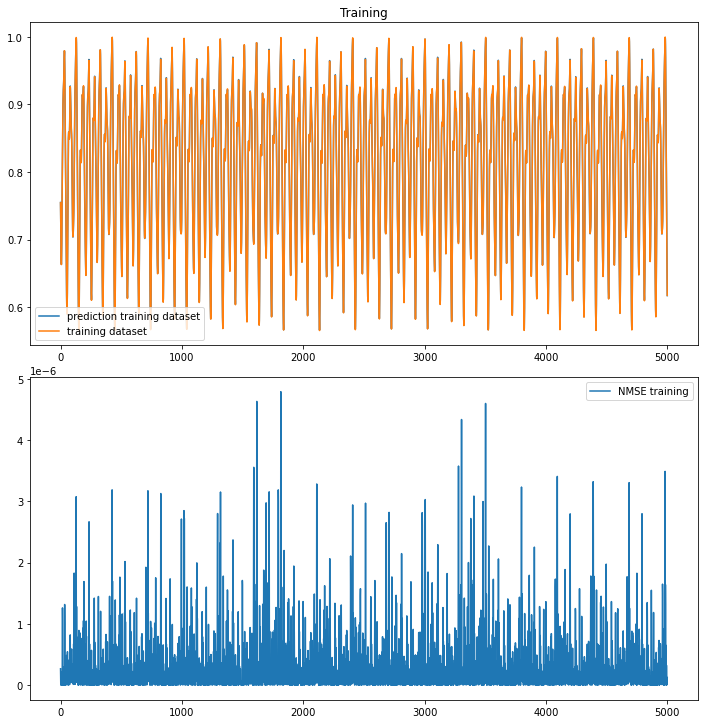

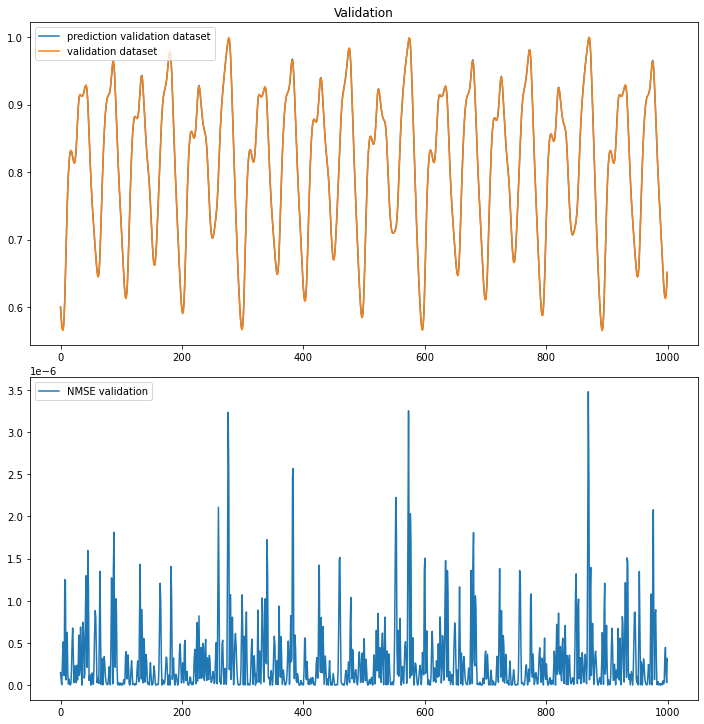

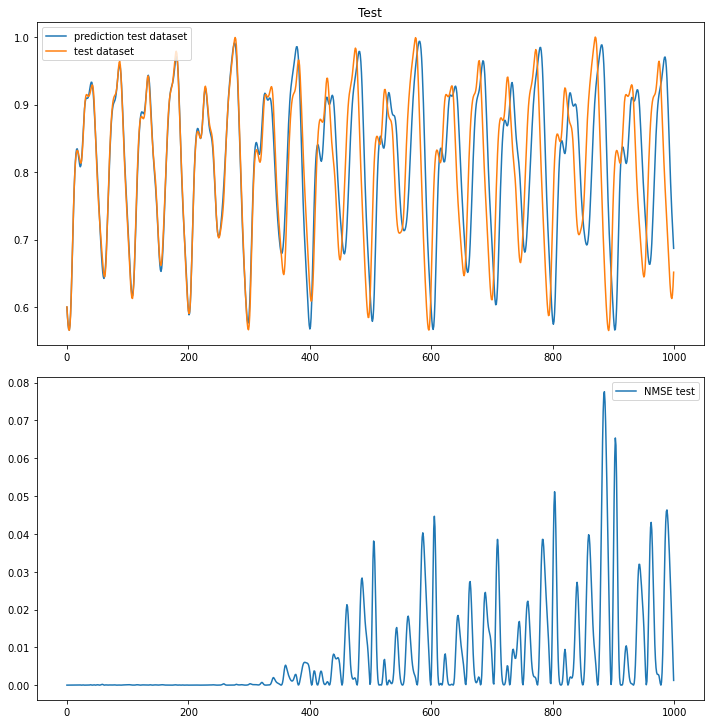

In [18]:
fac=10
Ttot=10000
Nt=fac*Ttot
x0=1.8
dt=0.1

ds=rc_datasets.mackeyglass(fac,Nt,dt,x0,0.2,0.1,17)
data=ds.u.reshape(1,Ttot)

my_esn=Esn(data,rhoscale=1.3, alpha=0.3, beta=1.3e-4, Ttrain=5000, Twashout=1000, N=1000)
# my_esn.plot_static_properties()
my_esn.train()
my_esn.validate(val_time=1000)
my_esn.test(test_time=1000)
my_esn.plot_training()
my_esn.plot_validation()
my_esn.plot_test()

NMSE training:1.12e-11
NMSE validation:1.12e-11
NMSE test:2.56e-10


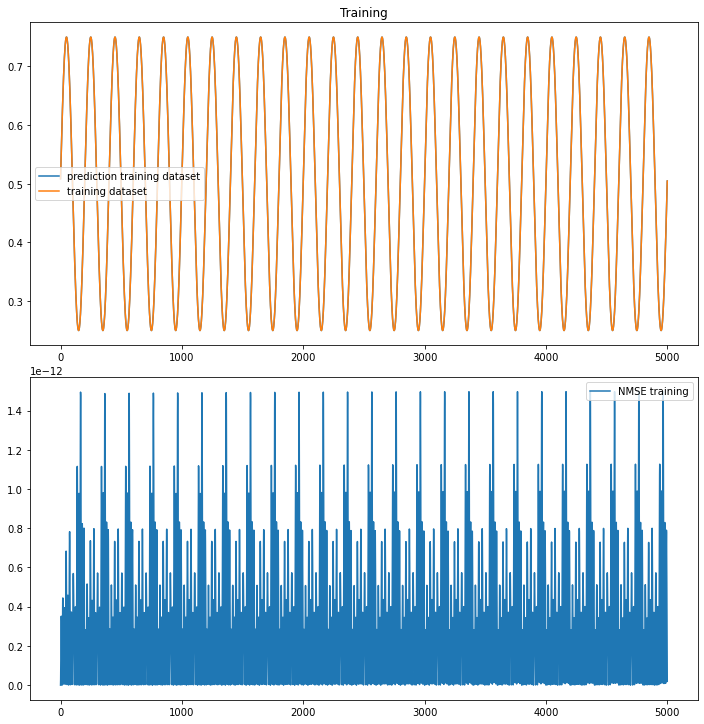

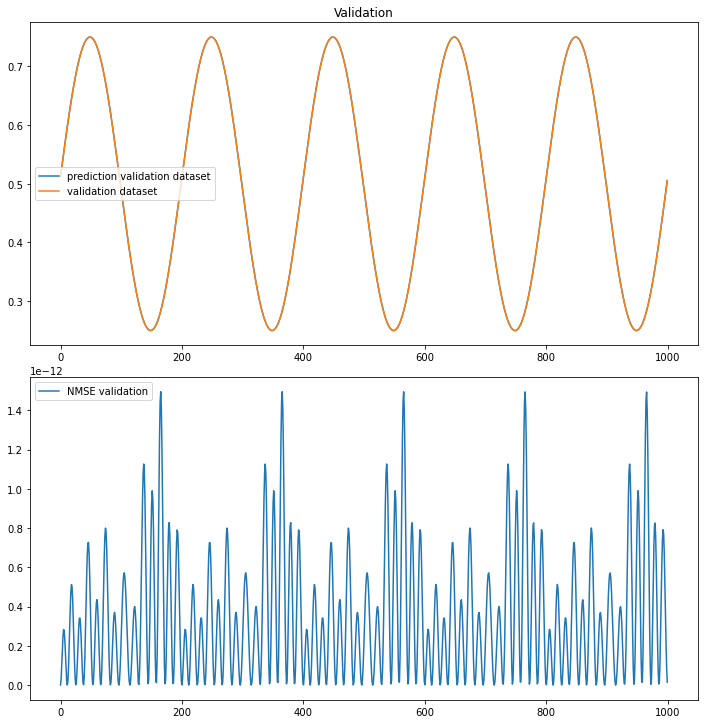

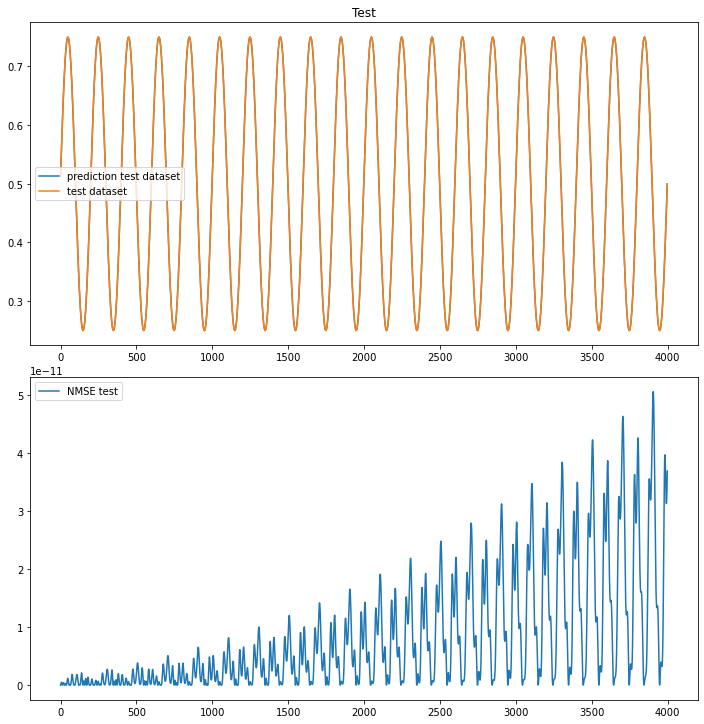

In [19]:
theta = np.linspace(0,50,Ttot)
data = 0.5+0.25*np.sin(2*np.pi*theta).reshape(1,Ttot)

my_esn=Esn(data,rhoscale=1.3, alpha=0.3, beta=1.3e-4, Ttrain=5000, Twashout=1000, N=1000)
# my_esn.plot_static_properties()
my_esn.train()
my_esn.validate(val_time=1000)
my_esn.test(test_time=3999)
my_esn.plot_training()
my_esn.plot_validation()
my_esn.plot_test()

NMSE training:1.31e-09
NMSE validation:1.29e-09
NMSE test:1.98e-04


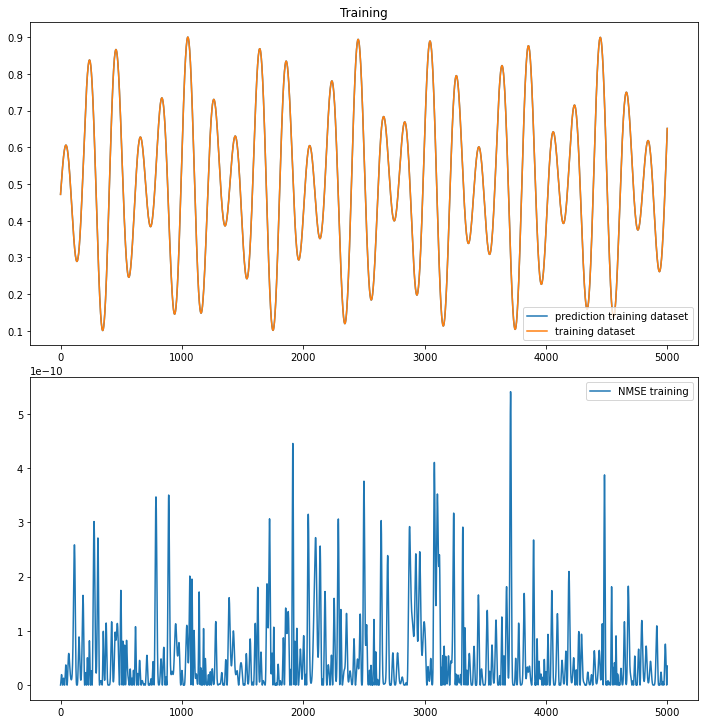

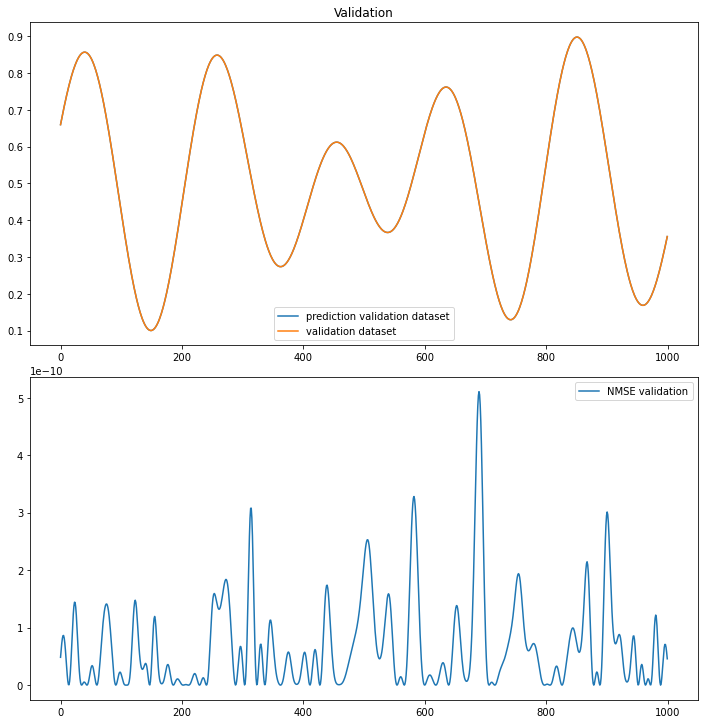

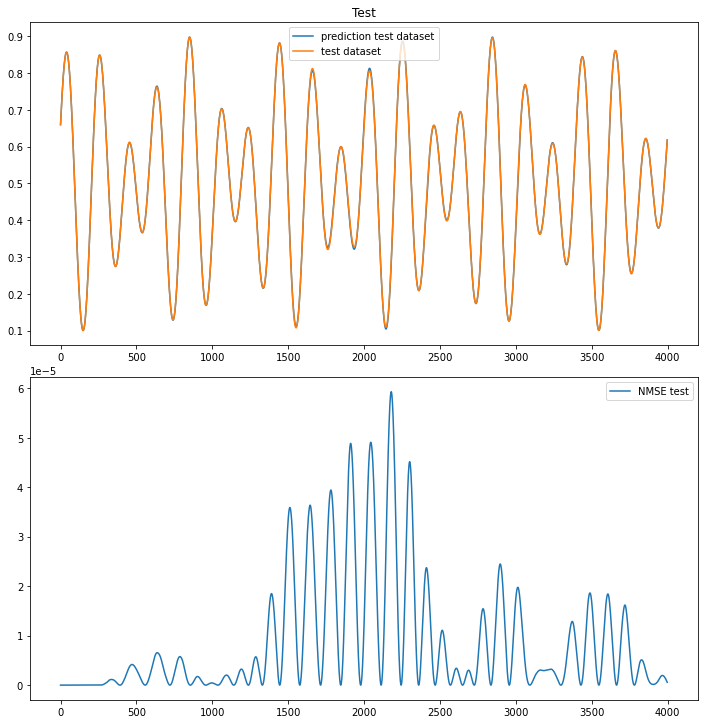

In [20]:
theta = np.linspace(0,50,Ttot)
data = 0.5+0.25*np.sin(2*np.pi*theta).reshape(1,Ttot)+0.15*np.sin(np.sqrt(2)*np.pi*theta).reshape(1,Ttot)

my_esn=Esn(data,rhoscale=1.3, alpha=0.3, beta=1.3e-4, Ttrain=5000, Twashout=1000, N=1000)
# my_esn.plot_static_properties()
my_esn.train()
my_esn.validate(val_time=1000)
my_esn.test(test_time=3999)
my_esn.plot_training()
my_esn.plot_validation()
my_esn.plot_test()

NMSE training:3.75e-05
NMSE validation:1.13e-04
NMSE test:9.95e-01


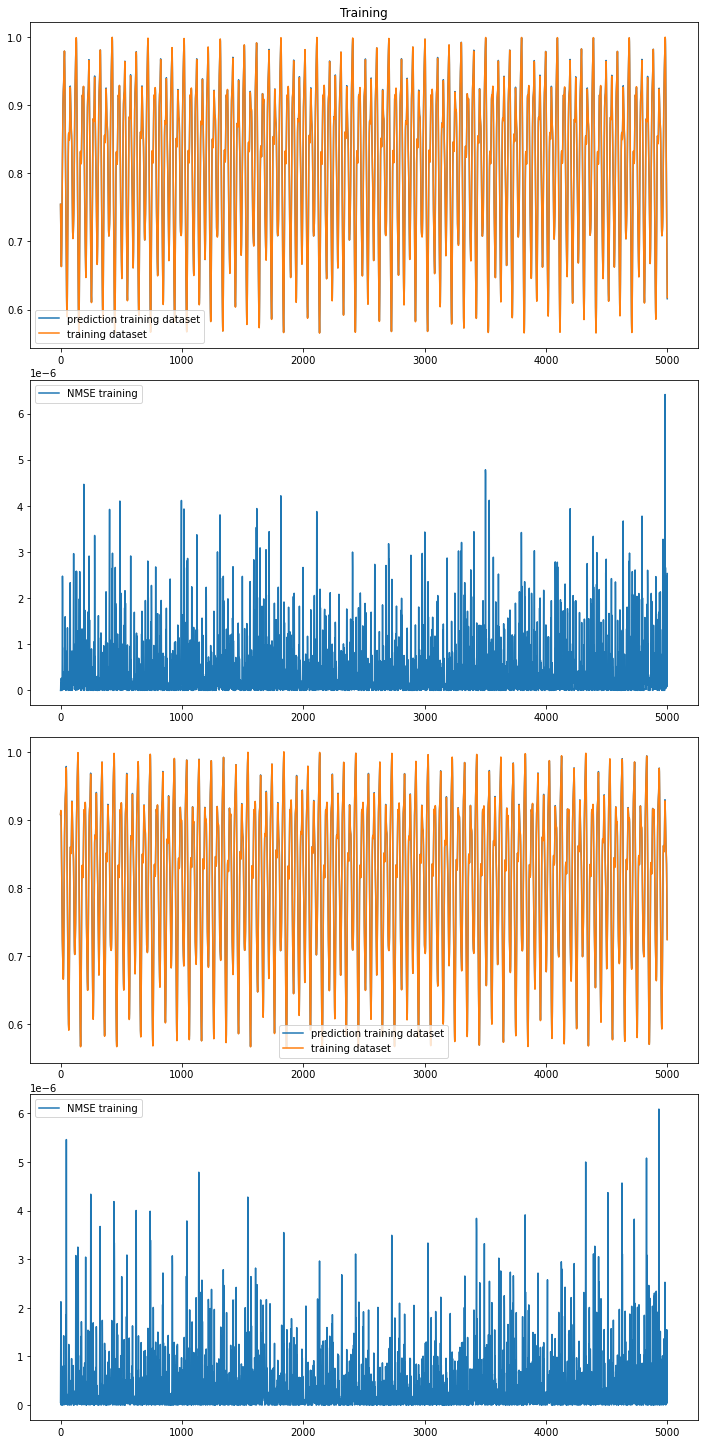

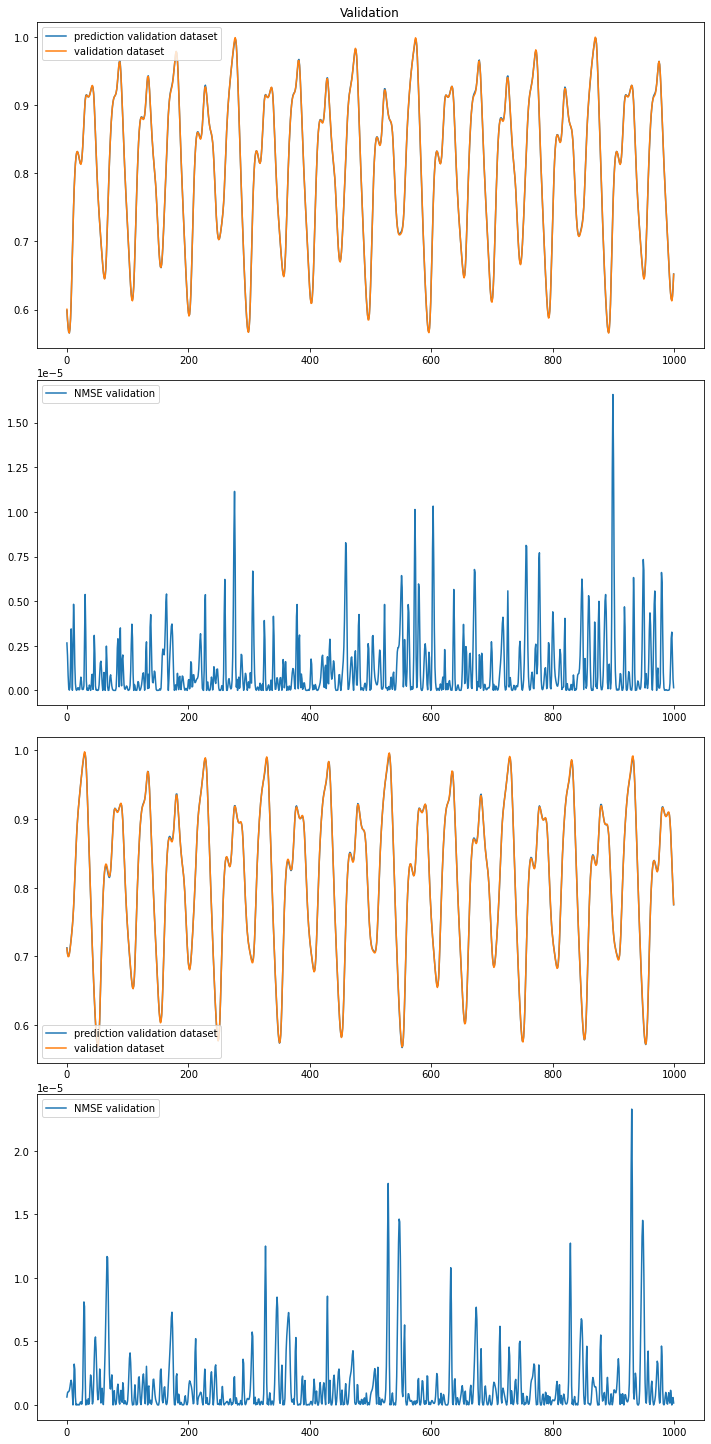

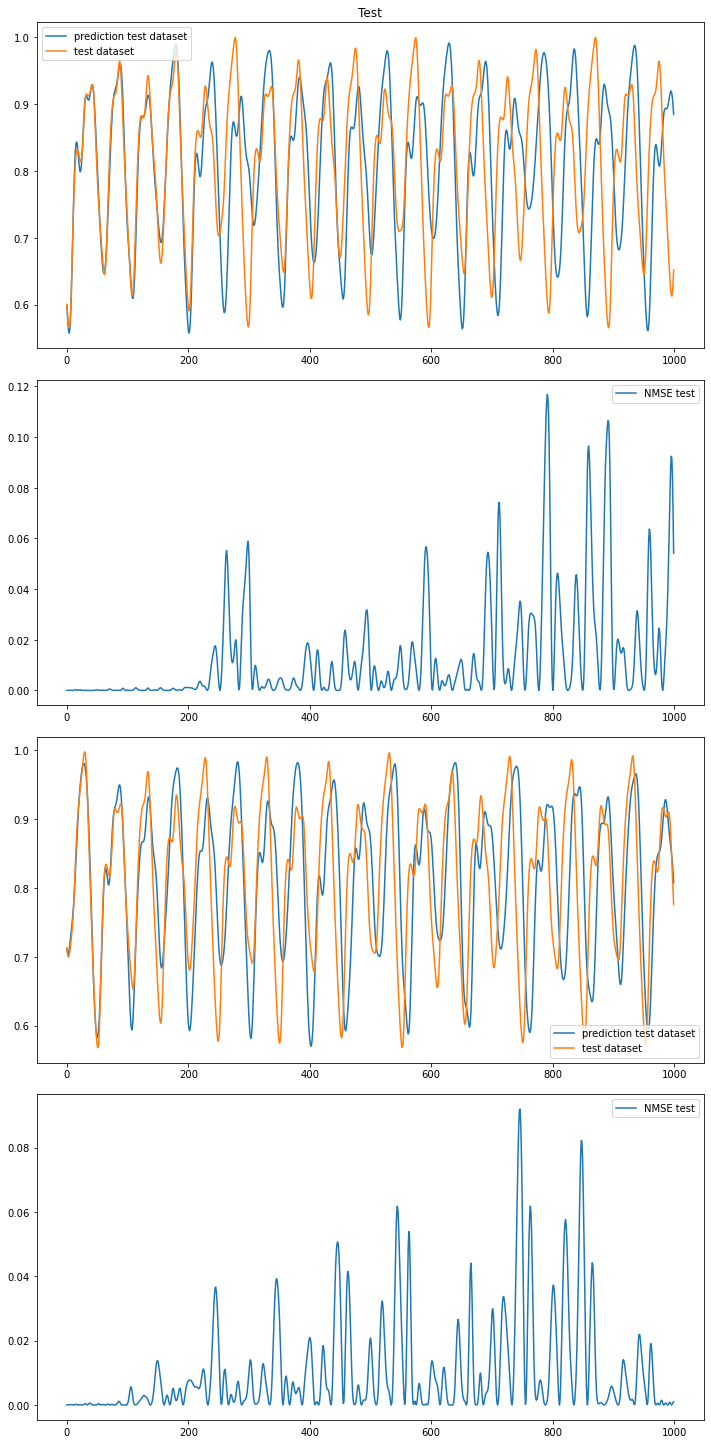

In [22]:
plt.rcParams['figure.figsize'] = [10, 20]

fac=10
Ttot=10000
Nt=fac*Ttot
x0=1.8
dt=0.1

ds=rc_datasets.mackeyglass(fac,Nt,dt,x0,0.2,0.1,17)

x0=2.6
ds2=rc_datasets.mackeyglass(fac,Nt,dt,x0,0.2,0.1,17)

data=np.concatenate((ds.u.reshape(1,Ttot),ds2.u.reshape(1,Ttot)))

my_esn=Esn(data,rhoscale=1.3, alpha=0.3, beta=1.3e-4, Ttrain=5000, Twashout=1000, N=1000,in_nodes=2,out_nodes=2)

my_esn.train()
my_esn.validate(val_time=1000)
my_esn.test(test_time=1000)
my_esn.plot_training()
my_esn.plot_validation()
my_esn.plot_test()